In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.tri import Triangulation

import ast

In [3]:
def parse_results(file_name):
    grid_search_results = []
    with open(file_name, 'r') as file:
        for line in file.readlines():
            if line[0:4] == '----':
                grid_search_results.append([])
                continue

            if line[0] == '(':
                fixed_line = '[' + line.strip().replace(') (', '), (') + ']'
                params = ast.literal_eval(fixed_line)
                nested = [list(zip(key.split(','), np.array(val).flatten())) for (key, val) in params]
                unnested = [item for sublist in nested for item in sublist]
                grid_search_results[-1].append({key: val for (key, val) in unnested})
                grid_search_results[-1].append([])
                continue

            result = line

            if result[0] == '[':
                grid_search_results[-1][-1].append(ast.literal_eval(result))
                continue

    grid_search_results = [(params, np.array(values)) for params, values in grid_search_results]
    return grid_search_results

In [63]:
both_res = parse_results('grid_search_results/both_mega_50.txt')
hyp_res = both_res[:len(both_res)//2]
euc_res = both_res[len(both_res)//2:]
# hyp_res = both_res
# euc_res = both_res

In [64]:
hyp_params = np.array([p for p, _ in hyp_res])
hyp_values = np.array([v for _, v in hyp_res])

euc_params = np.array([p for p, _ in euc_res])
euc_values = np.array([v for _, v in euc_res])

hyp_values.shape, euc_values.shape

((576, 5, 50), (576, 5, 50))

In [65]:
NUM_HIDDEN_LAYERS = sorted(list(set([p['num_hidden_layers'] for p in hyp_params]).union(set([p['num_hidden_layers'] for p in euc_params]))))
LAYER_SIZE = sorted(list(set([p['layer_size'] for p in hyp_params]).union(set([p['layer_size'] for p in euc_params]))))
LR = sorted(list(set([p['lr'] for p in hyp_params]).union(set([p['lr'] for p in euc_params]))))
WD = sorted(list(set([p['weight_decay'] for p in hyp_params]).union(set([p['weight_decay'] for p in euc_params]))))

In [66]:
print(NUM_HIDDEN_LAYERS)
print(LAYER_SIZE)
print(LR)
print(WD)

[0, 1, 2, 4]
[16, 32, 64, 128, 256, 512, 1024, 1536, 2048]
[0.01, 0.02, 0.025, 0.03]
[0.01, 0.02, 0.025, 0.03]


In [67]:
num_hidden_layers = np.array(NUM_HIDDEN_LAYERS).repeat(len(LAYER_SIZE))
layer_size = np.tile(LAYER_SIZE, len(NUM_HIDDEN_LAYERS))

In [68]:
hyp_values[0::len(WD)].mean(axis=1)[:,-1].reshape(-1,len(LR))[:,0].shape

(36,)

In [69]:
num_hidden_layers.shape, layer_size.shape

((36,), (36,))

--------------- Weight Decay: 0.01 ---------------


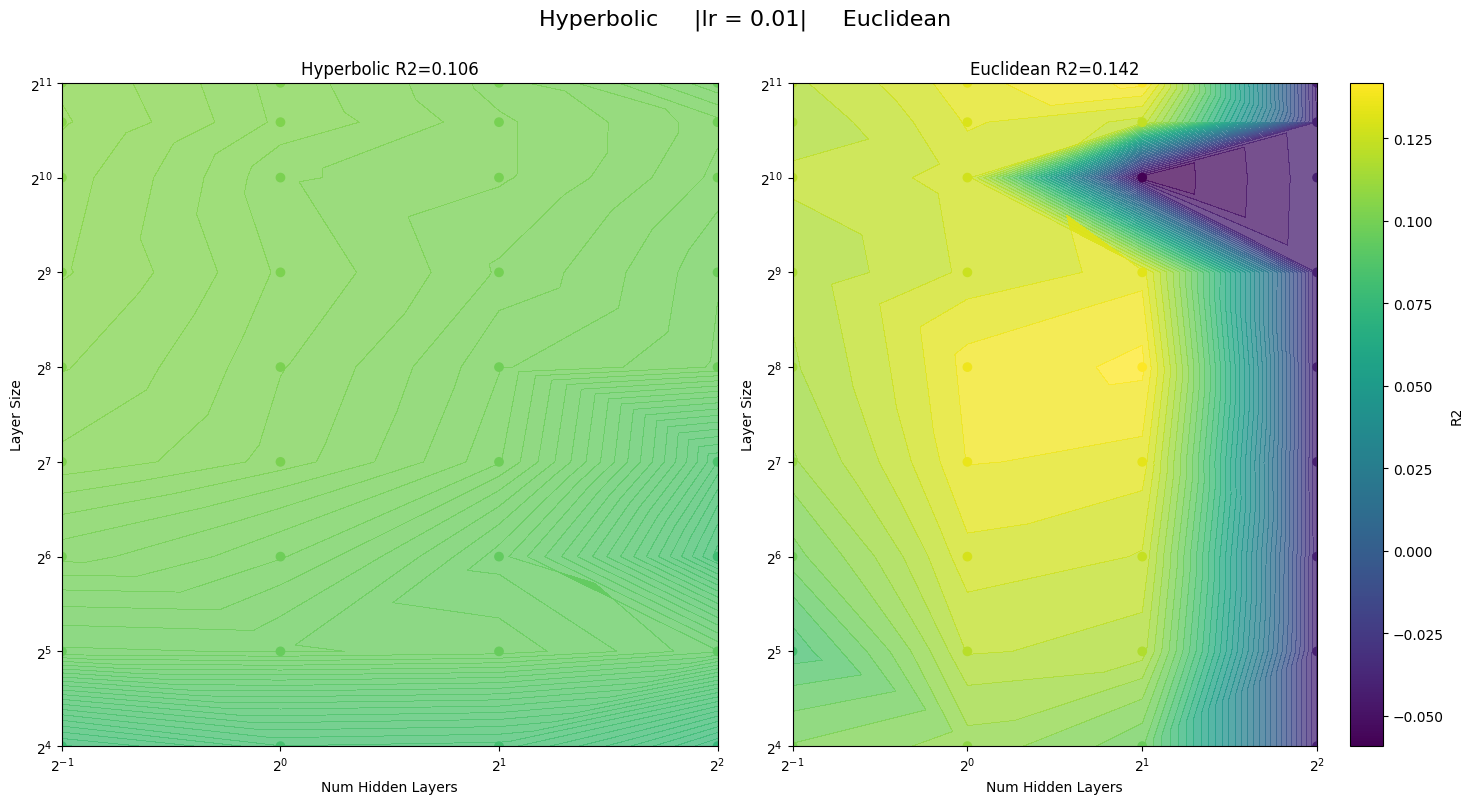

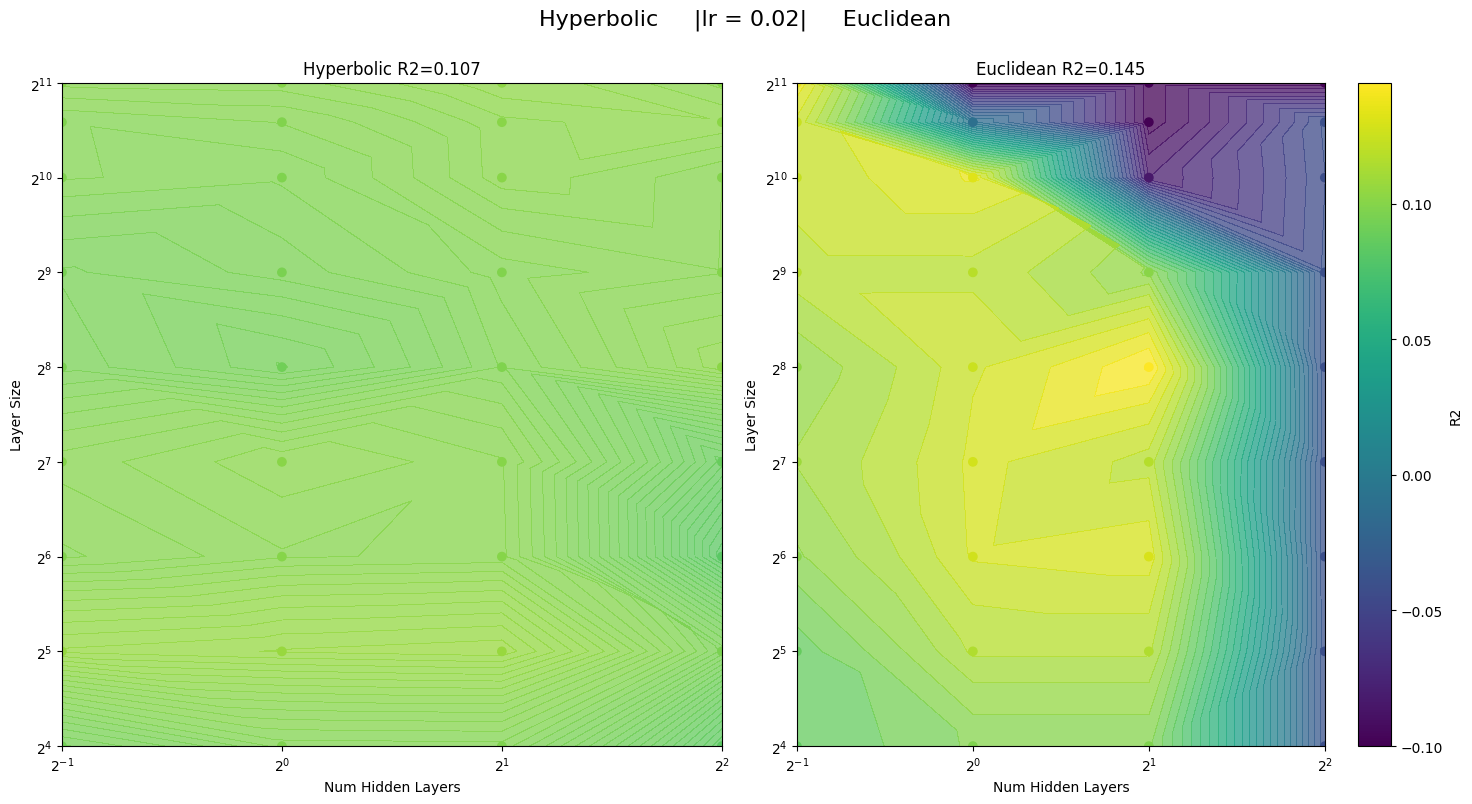

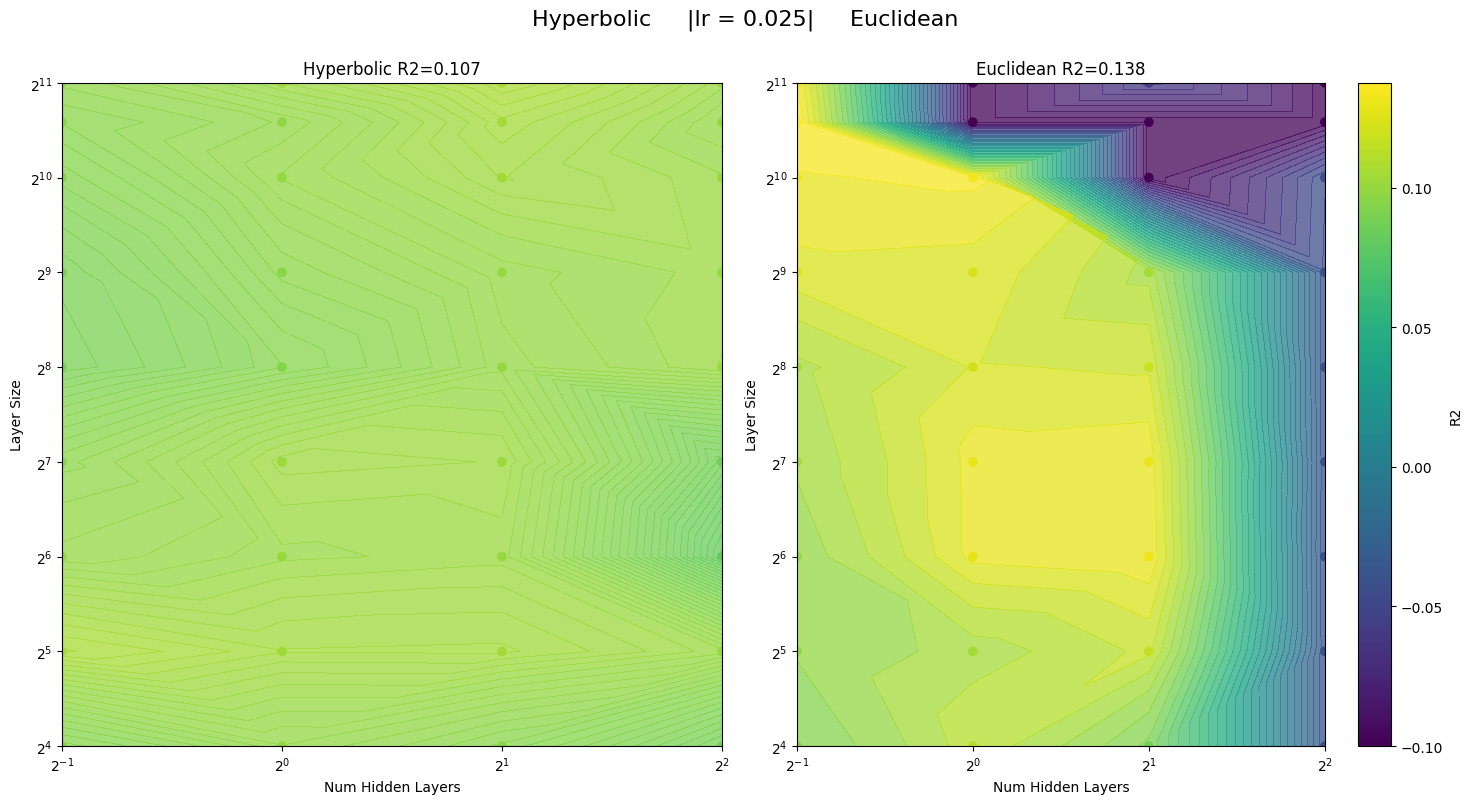

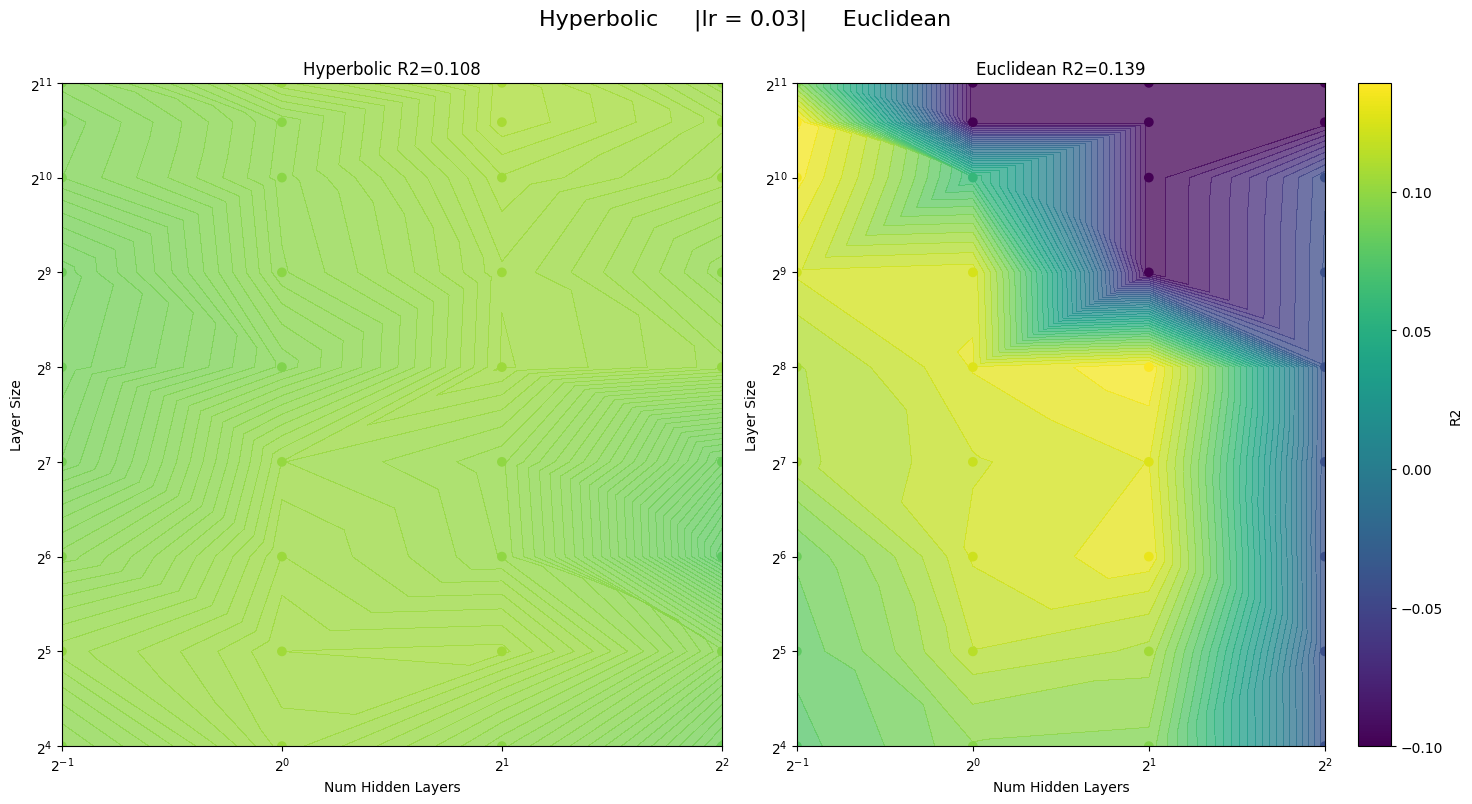

--------------- Weight Decay: 0.02 ---------------


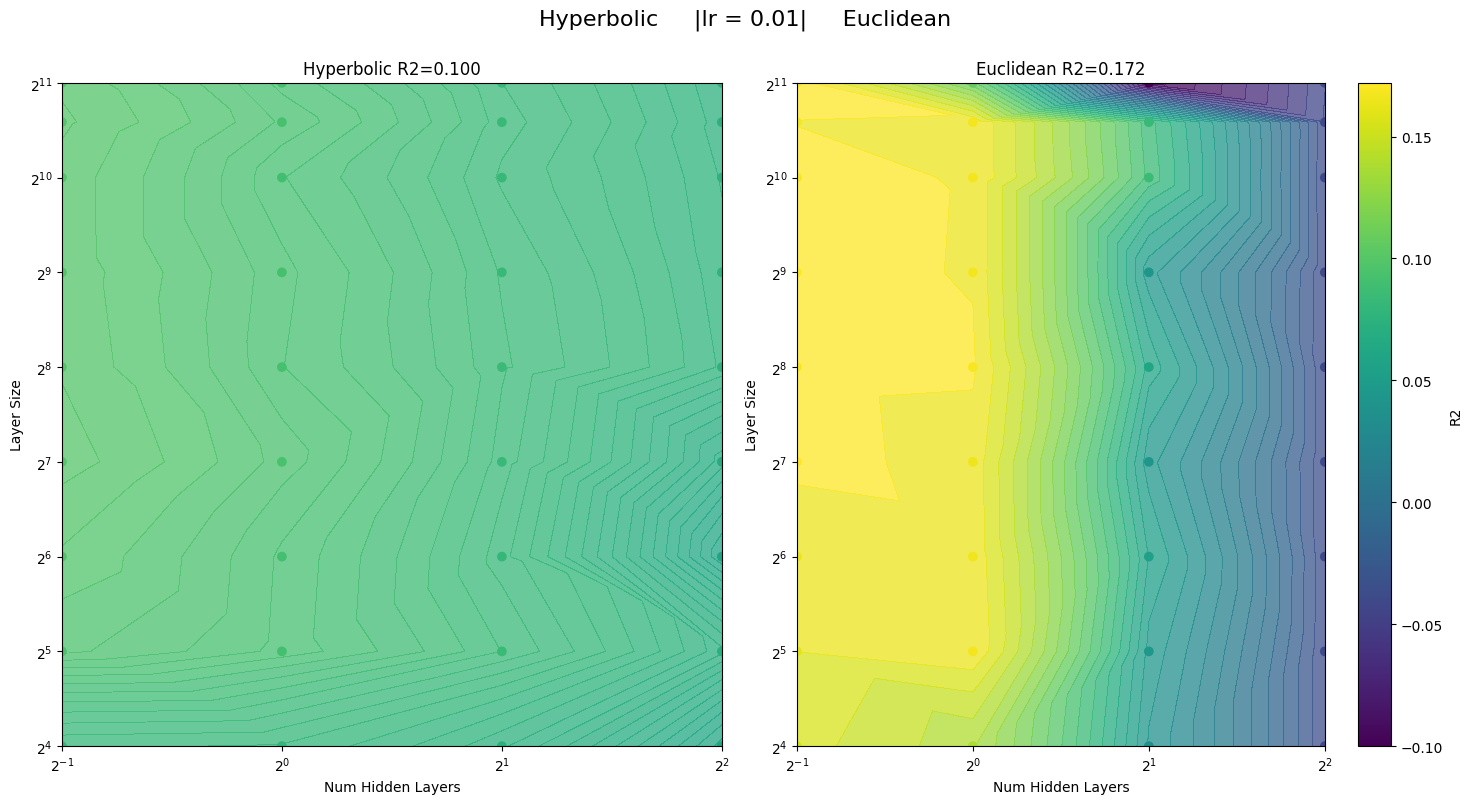

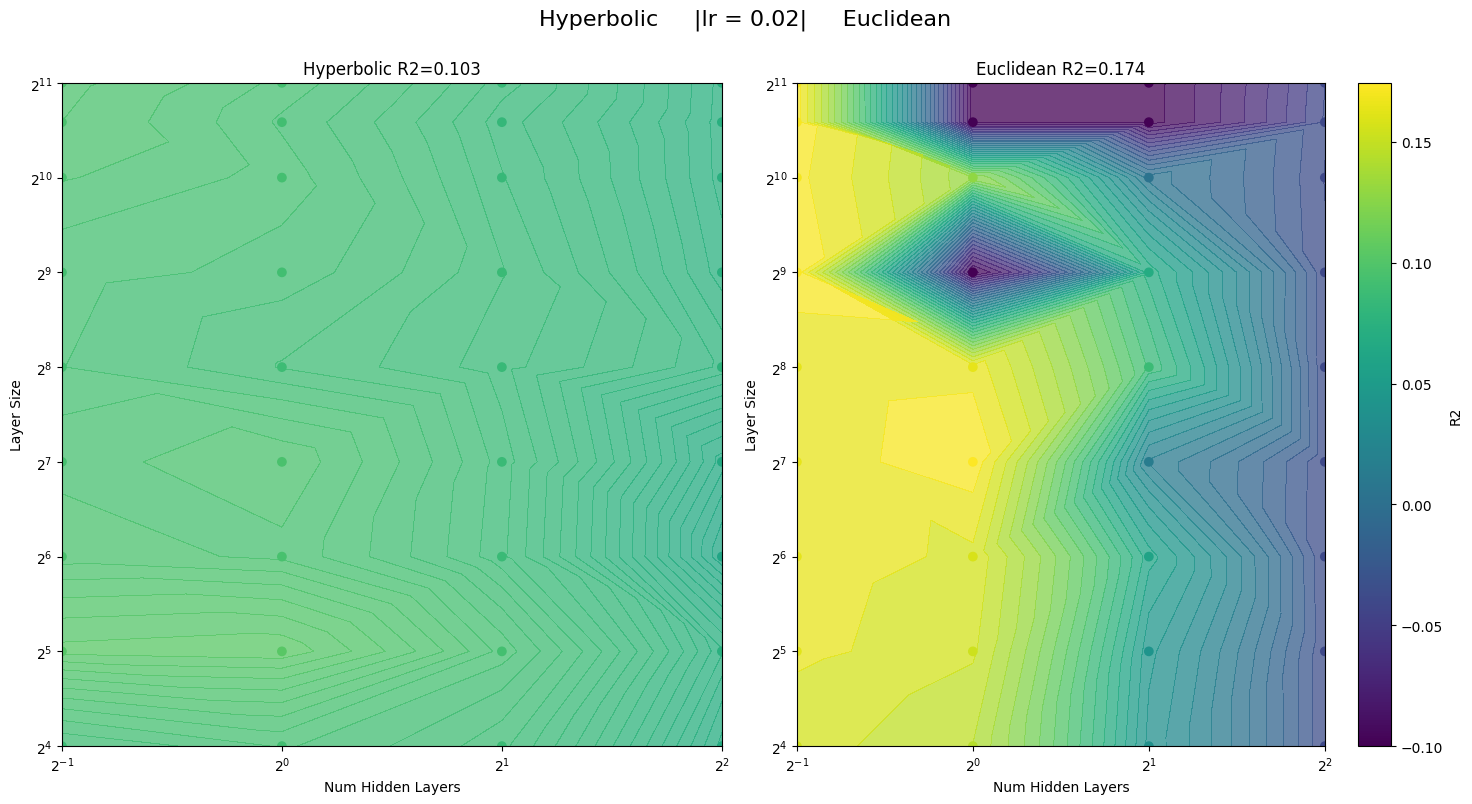

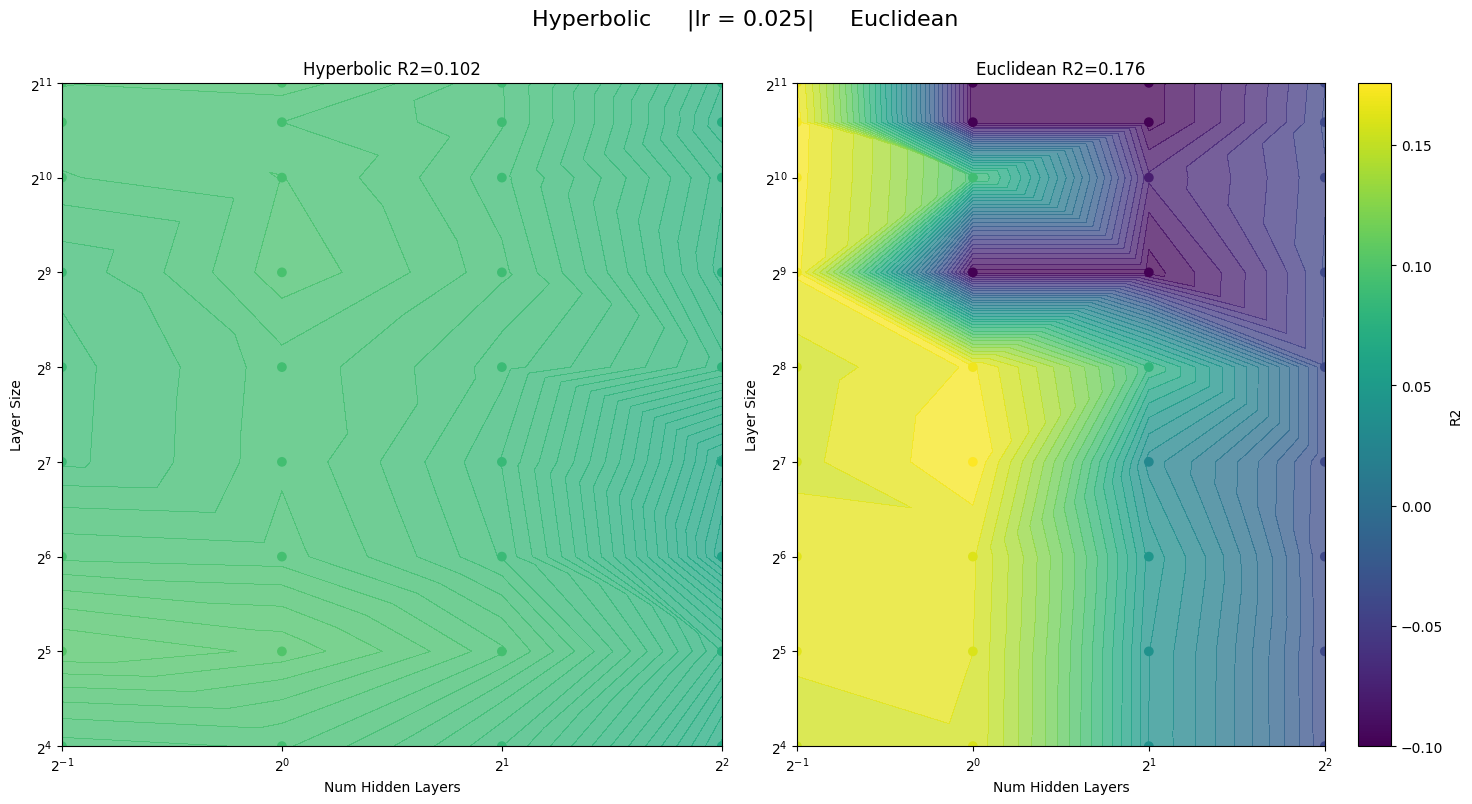

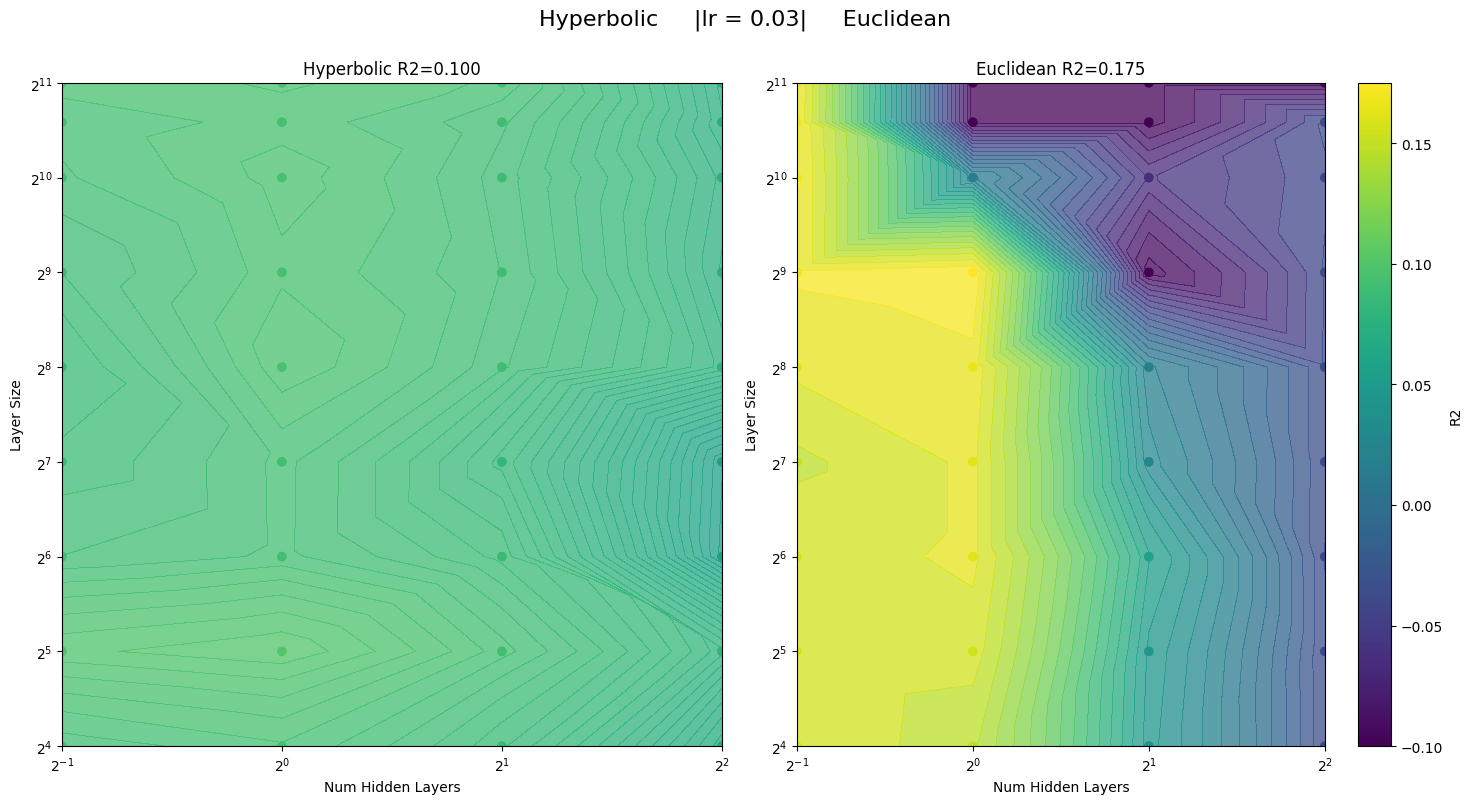

--------------- Weight Decay: 0.025 ---------------


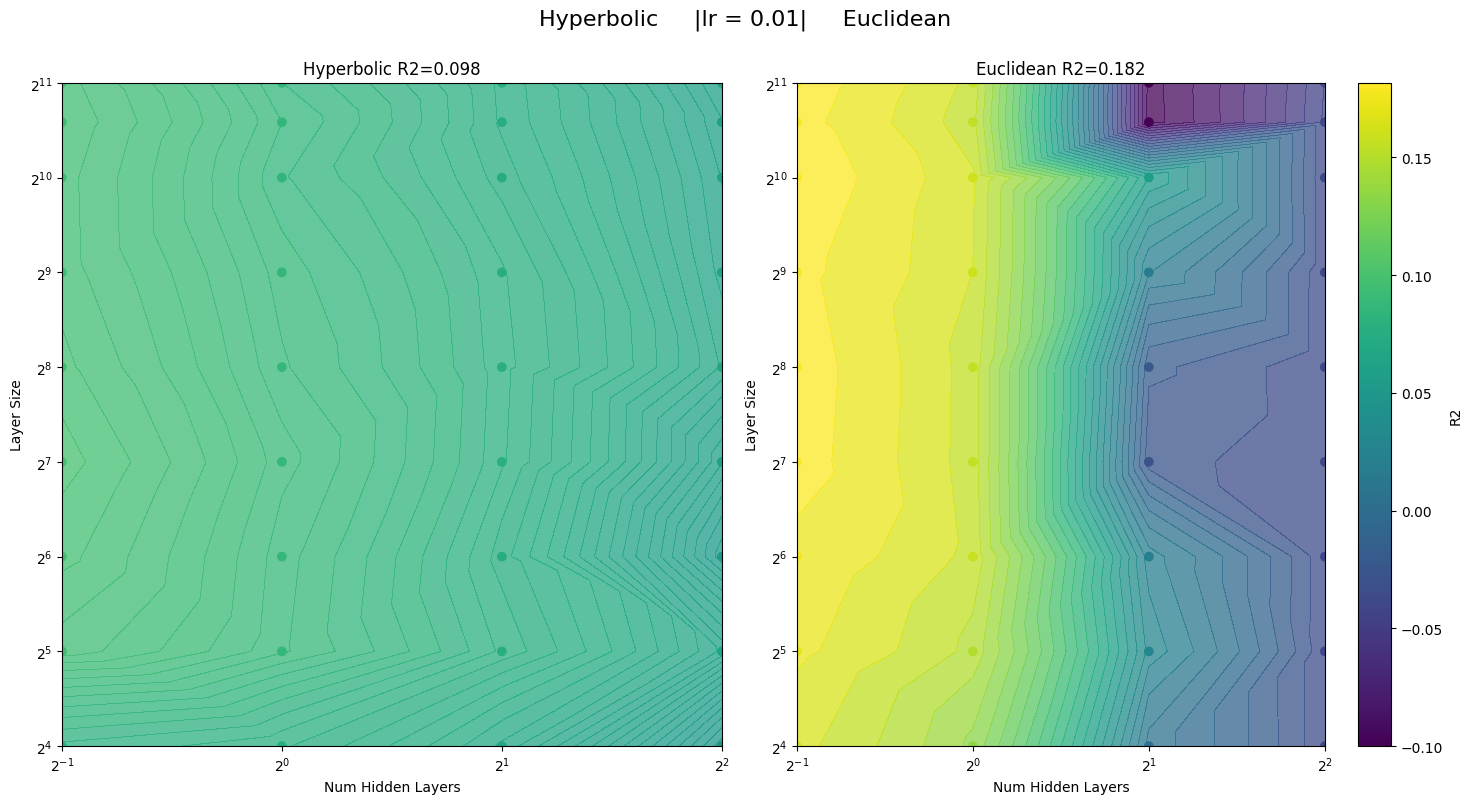

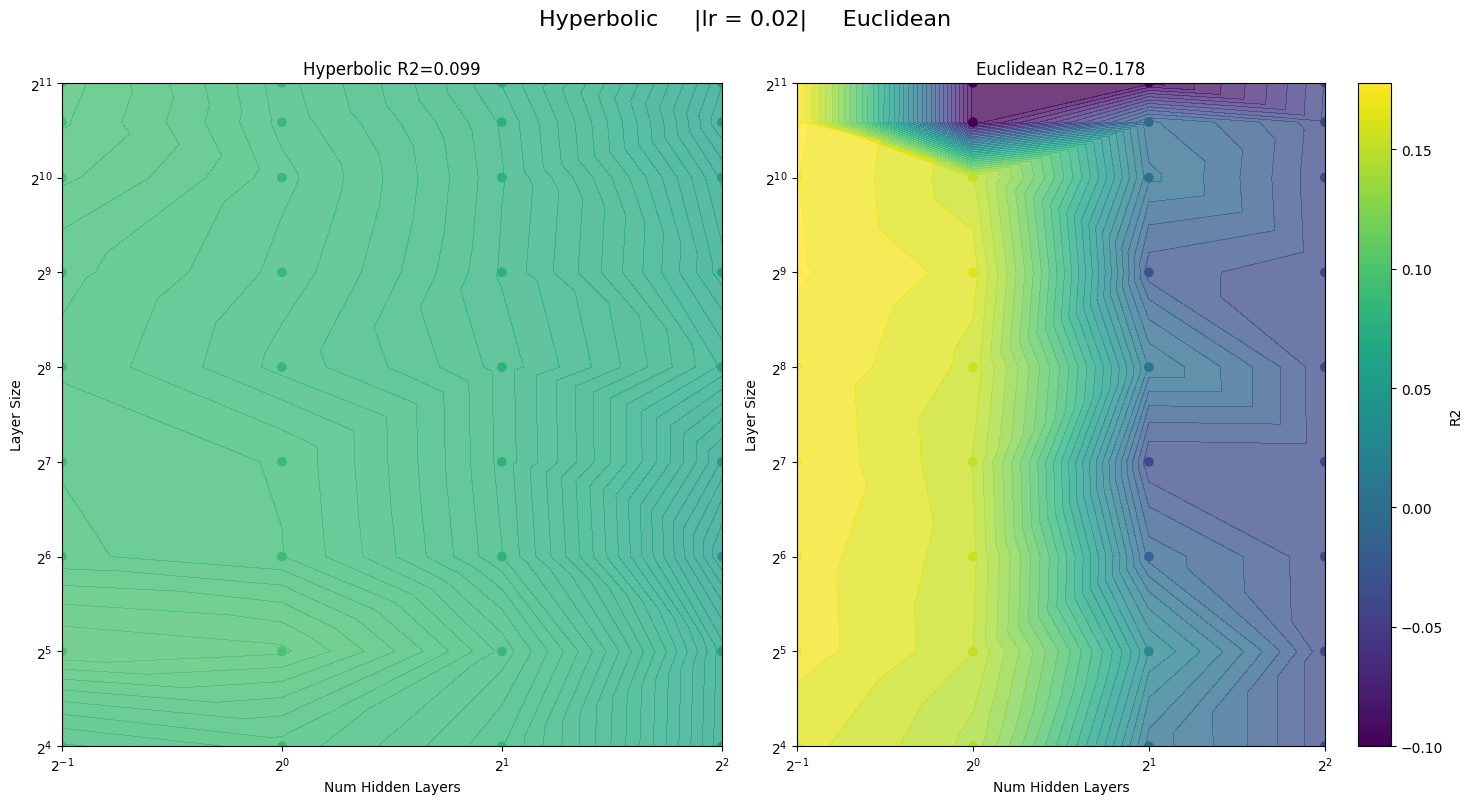

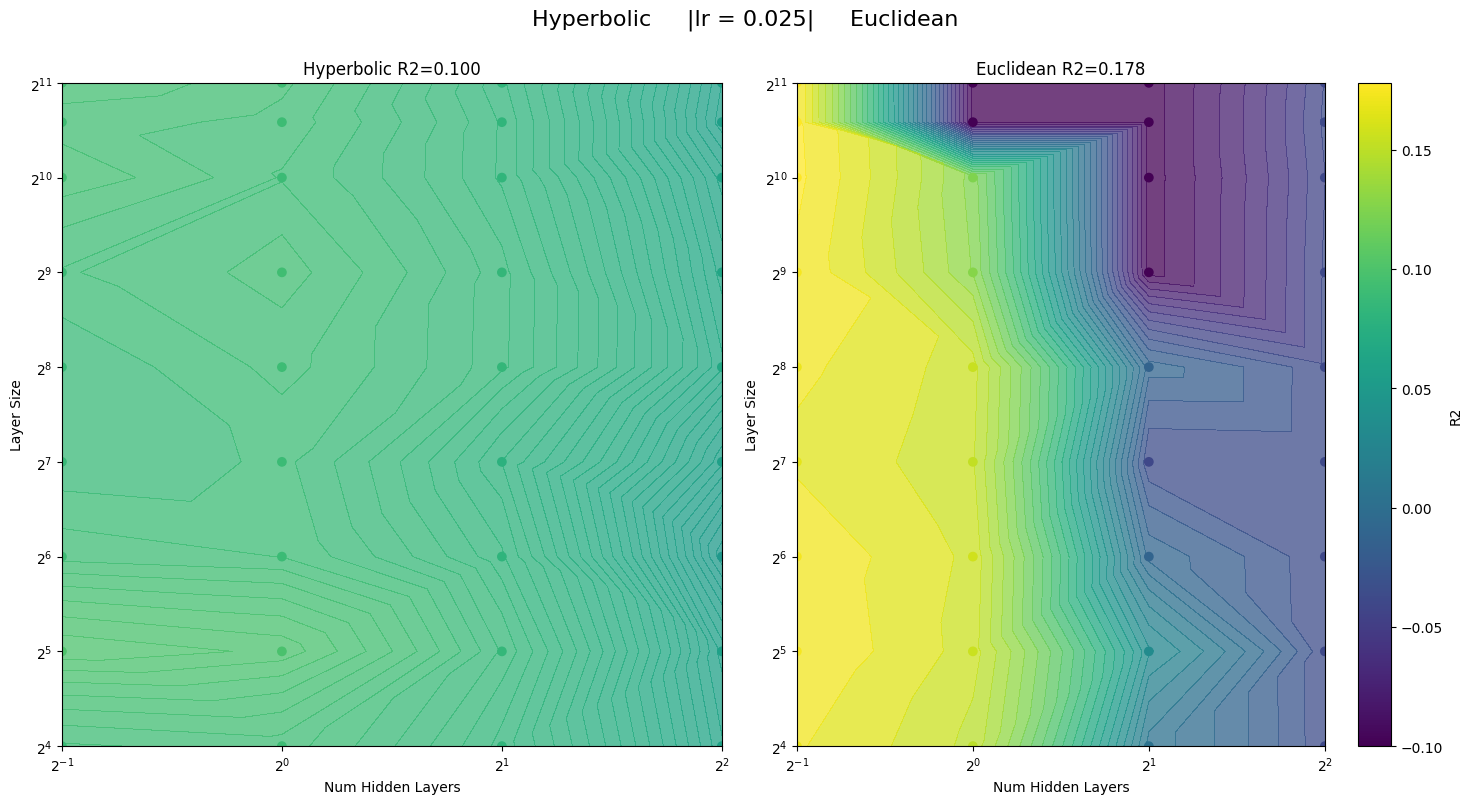

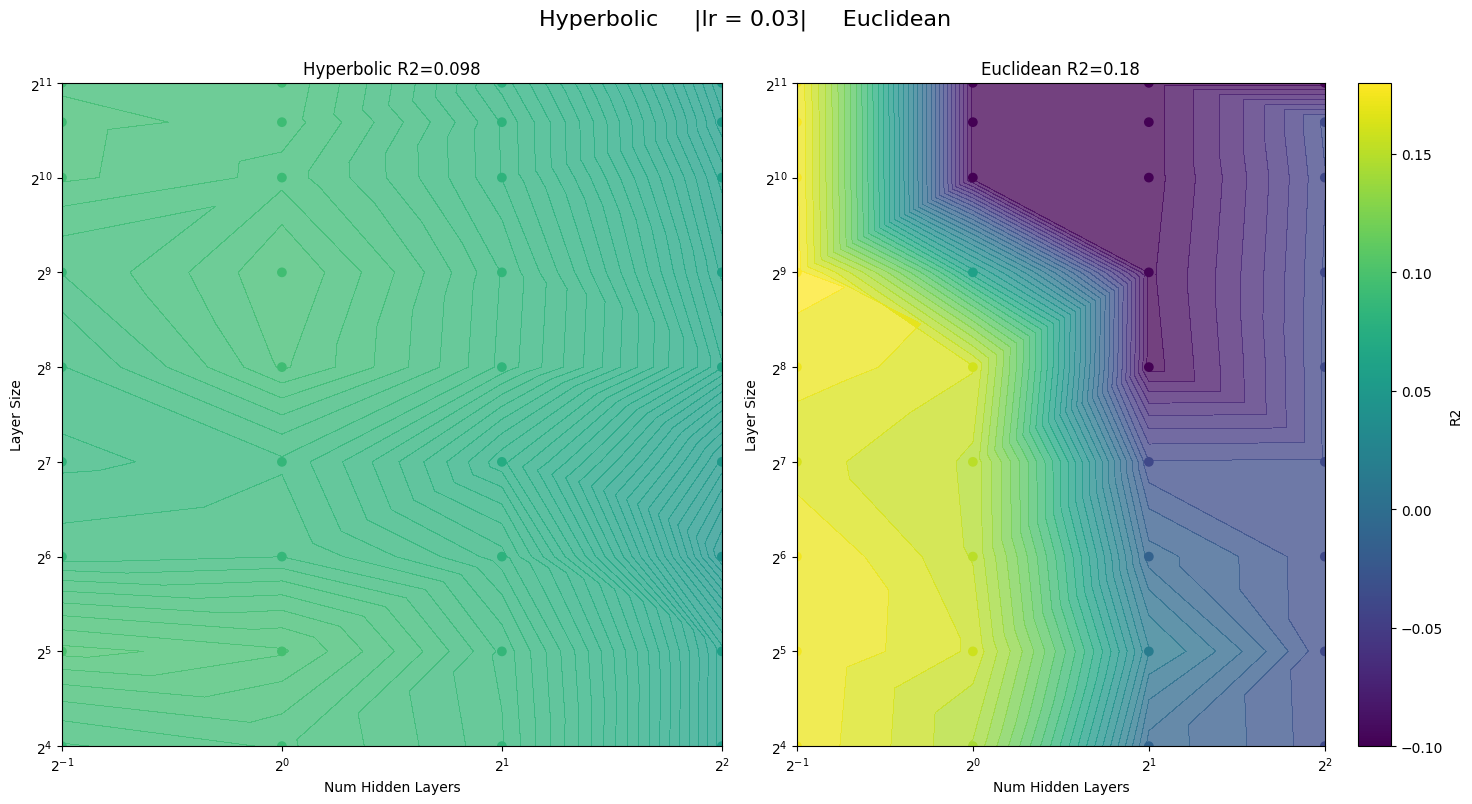

--------------- Weight Decay: 0.03 ---------------


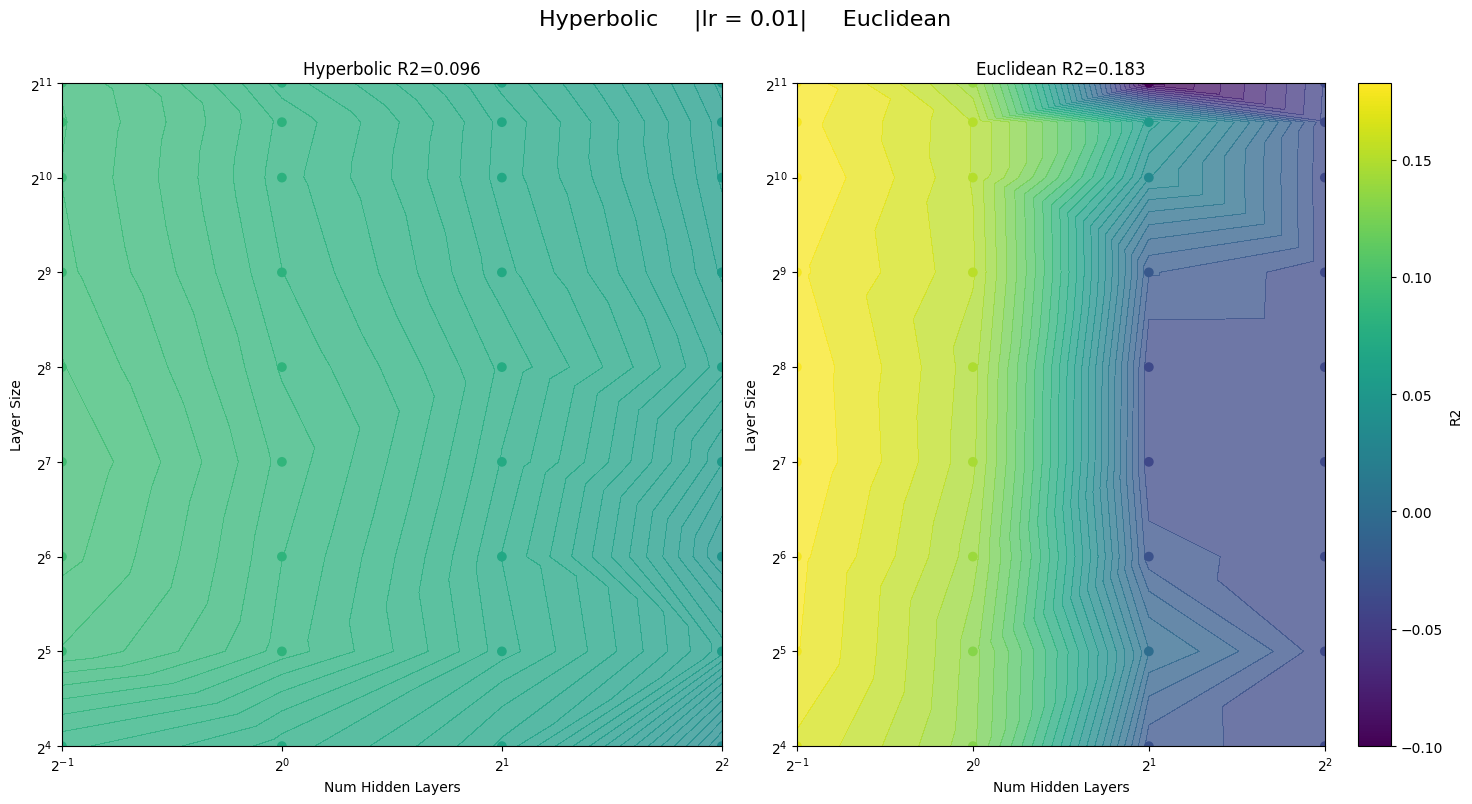

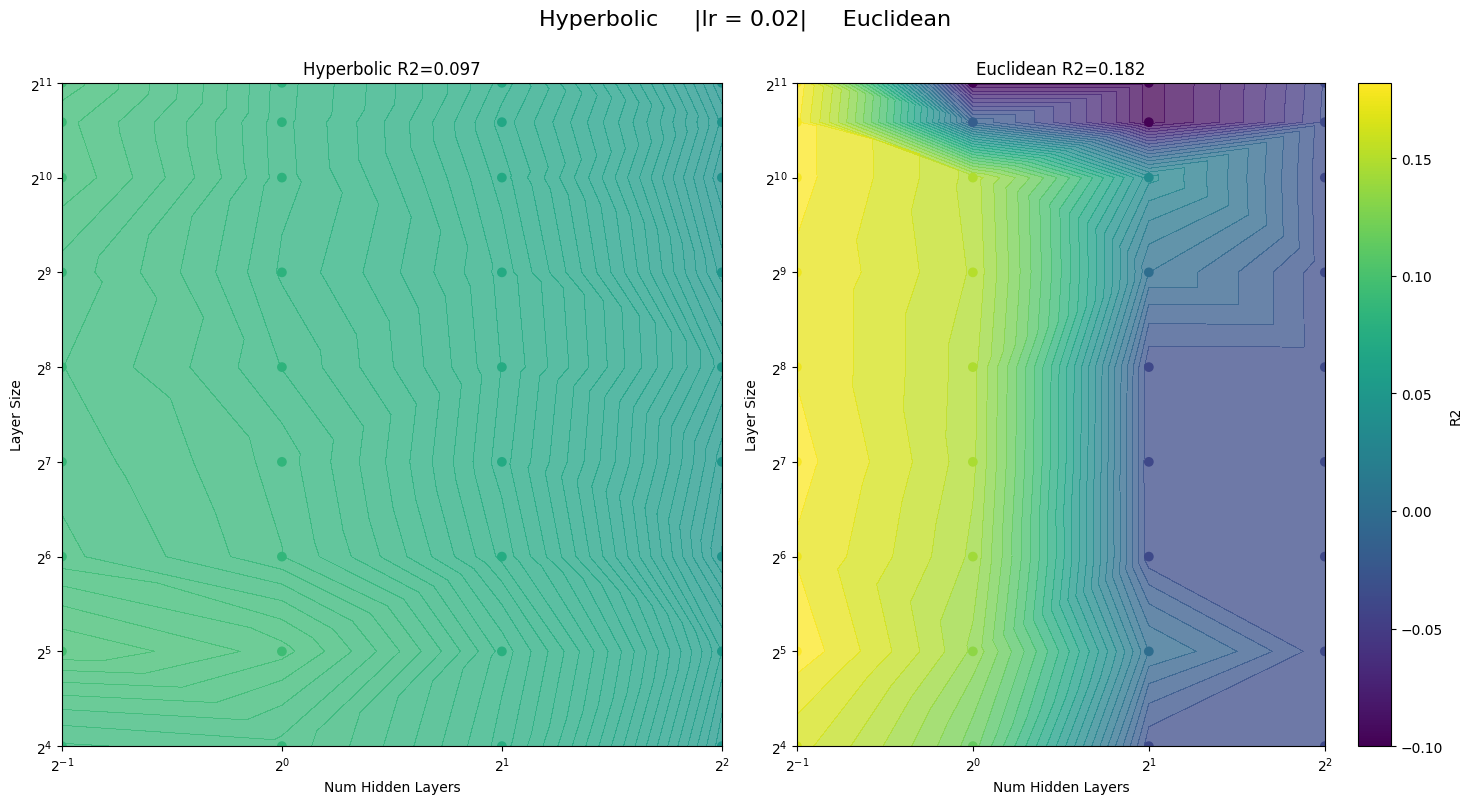

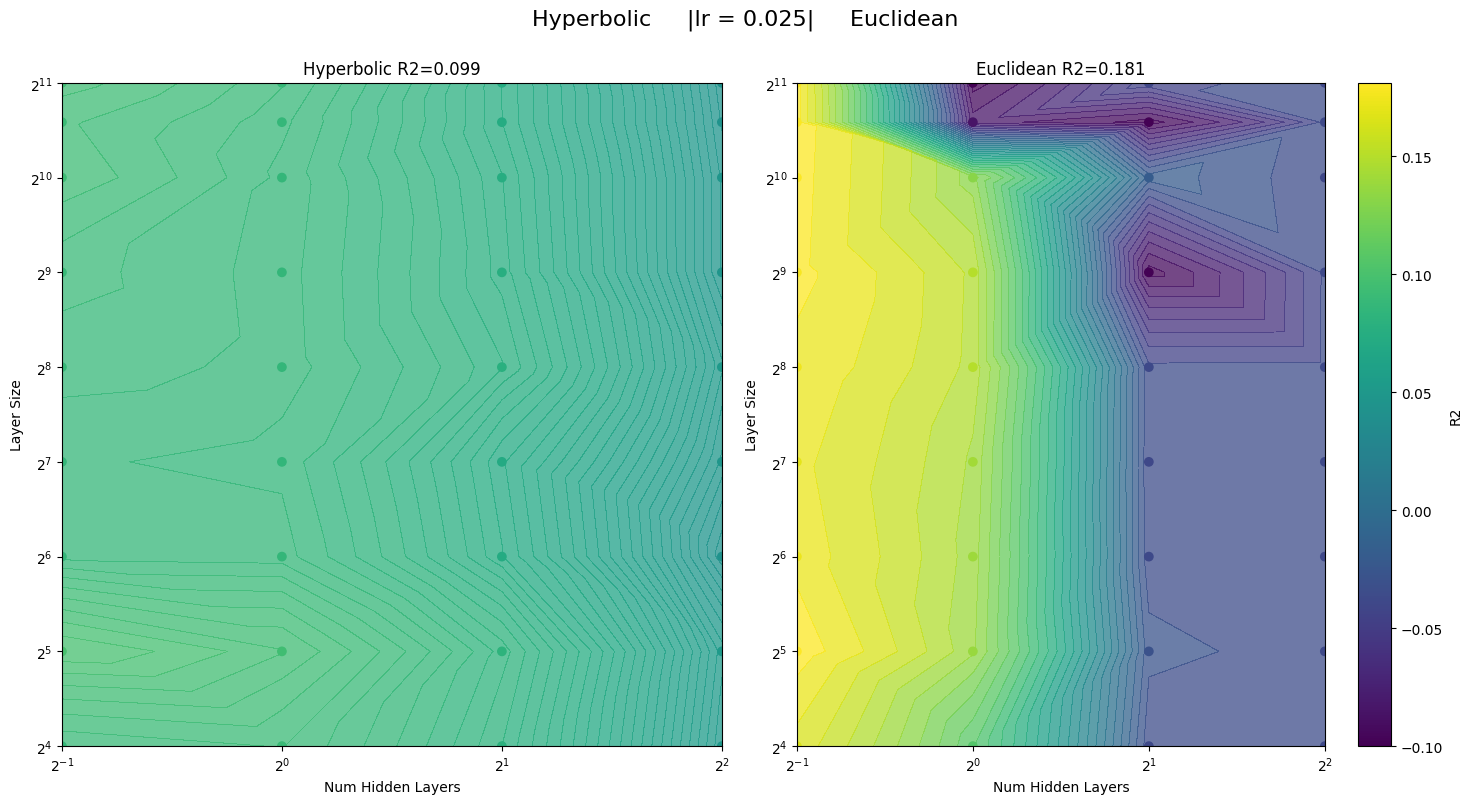

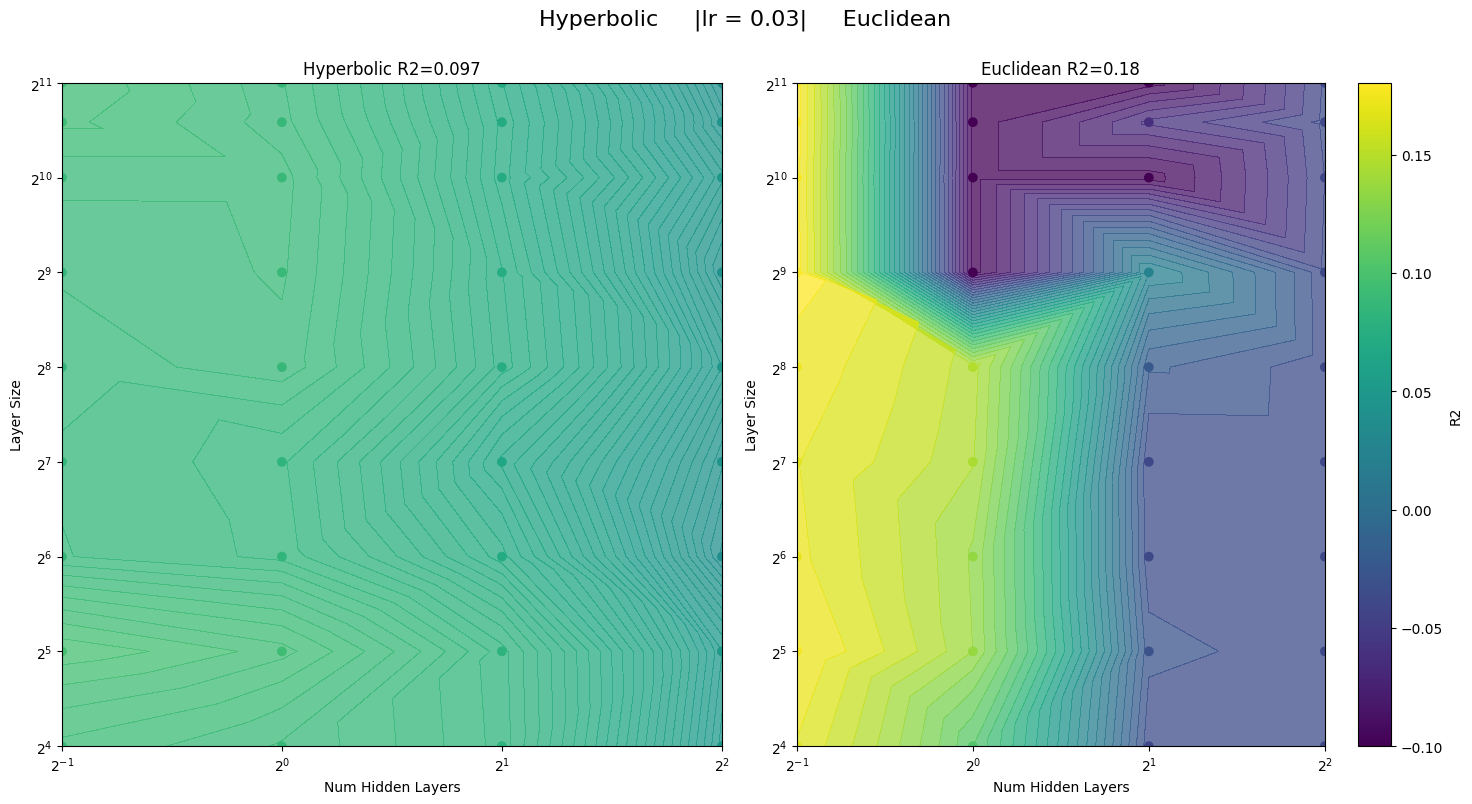

In [72]:
for i, wd in enumerate(WD):
    print(f'--------------- Weight Decay: {wd} ---------------')
    hyp_values_wd = hyp_values[i::len(WD)]
    euc_values_wd = euc_values[i::len(WD)]
    for i, lr in enumerate(LR):
        hyp_data = hyp_values_wd.mean(axis=1)[:,19].reshape(-1,len(LR))[:,i].clip(-0.1)
        euc_data = euc_values_wd.mean(axis=1)[:,49].reshape(-1,len(LR))[:,i].clip(-0.1)

        min_val = min(np.min(hyp_data), np.min(euc_data))
        max_val = max(np.max(hyp_data), np.max(euc_data))

        cmap = plt.cm.viridis
        norm = Normalize(vmin=min_val, vmax=max_val)


        num_hidden_layers_adjust = num_hidden_layers.astype(float)
        num_hidden_layers_adjust[num_hidden_layers_adjust == 0] = 0.5

        mesh = Triangulation(num_hidden_layers_adjust, layer_size)  #create tri mesh


        plt.figure(figsize=(15,8))
        plt.suptitle(f'Hyperbolic     |lr = {lr}|     Euclidean', fontsize=16, y=1)

        plt.subplot(121)
        plt.tricontourf(mesh, hyp_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        plt.scatter(num_hidden_layers_adjust, layer_size, c=hyp_data, cmap=cmap, norm=norm)

        plt.title(f'Hyperbolic R2={np.max(hyp_data):.3f}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)


        plt.subplot(122)
        euc_contourf = plt.tricontourf(mesh, euc_data, levels=40, cmap=cmap, norm=norm, alpha=0.75)
        euc_scatter = plt.scatter(num_hidden_layers_adjust, layer_size, c=euc_data, cmap=cmap, norm=norm)
        plt.colorbar(euc_scatter, label='R2')


        plt.title(f'Euclidean R2={np.max(euc_data):.3}')
        plt.xlabel('Num Hidden Layers')
        plt.ylabel('Layer Size')

        plt.xscale('log', base=2)
        plt.yscale('log', base=2)

        plt.tight_layout()
        plt.show()

<h3>ALL</h3>

- Hyp: 0.116
- Euc: 0.185

<h3>BOTH</h3>

- Hyp: 0.120
- Euc: 0.139

<h3>AROMA</h3>

- Hyp: 0.099
- Euc: 0.100

<h3>FLAVOUR</h3>

- Hyp: 0.157
- Euc: 0.159


In [71]:
print(np.mean(hyp_values.mean(axis=1)[:,9]))
print(np.mean(hyp_values.mean(axis=1)[:,19]))
print(np.mean(hyp_values.mean(axis=1)[:,29]))
print(np.mean(hyp_values.mean(axis=1)[:,39]))
print(np.mean(hyp_values.mean(axis=1)[:,49]))
print()
print(np.mean(euc_values.mean(axis=1)[:,9]))
print(np.mean(euc_values.mean(axis=1)[:,19]))
print(np.mean(euc_values.mean(axis=1)[:,29]))
print(np.mean(euc_values.mean(axis=1)[:,39]))
print(np.mean(euc_values.mean(axis=1)[:,49]))
print()
print(hyp_values.mean(axis=1).max(axis=0).argmax())
print(euc_values.mean(axis=1).max(axis=0).argmax())

0.0813405102988701
0.08436538395232793
0.08152796751042901
0.07913492698259647
0.07751229962351057

-2125592.144645164
-48991.27922197928
-58599.71953211467
-180621.69948581068
-2820.472878102211

7
22


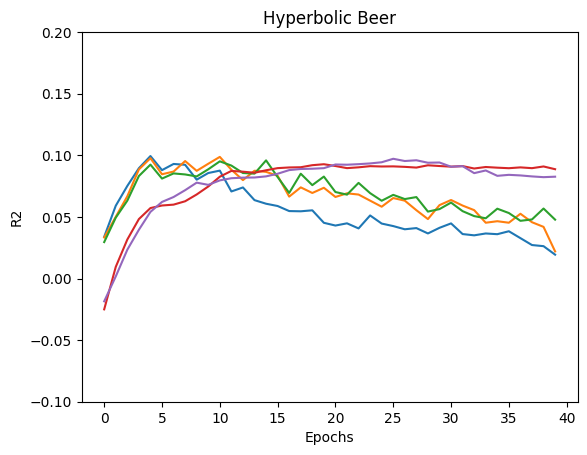

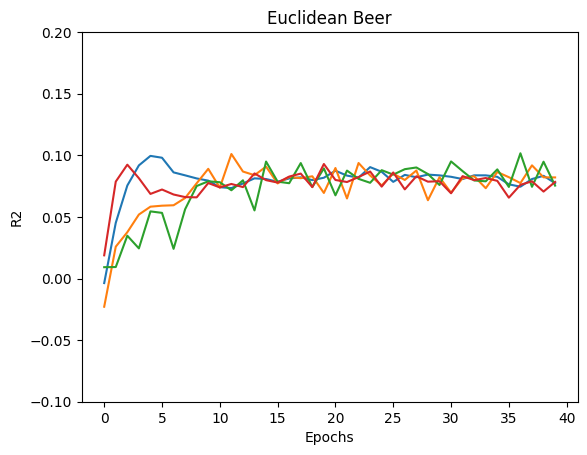

In [34]:
for run in hyp_values.mean(axis=1)[[472,772,773,877,1032]]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Hyperbolic Beer')
plt.ylabel('R2')
plt.xlabel('Epochs')

plt.ylim(-0.1,0.2)
# plt.yscale('log')
plt.show()

for run in euc_values.mean(axis=1)[[179,484,509,184]]:
    plt.plot(run)
    # plt.plot(run[25:])

plt.title('Euclidean Beer')
plt.ylabel('R2')
plt.xlabel('Epochs')

plt.ylim(-0.1,0.2)
# plt.yscale('log')
plt.show()
